# Product Description Clustering with TF-IDF, SVD & KMeans

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import numpy as np


## Load and Clean Data

In [3]:
df = pd.read_excel("/content/Cleaned_Online_Retail.xlsx")
df.dropna(subset=['Description'], inplace=True)
df.drop_duplicates(subset=['Description'], inplace=True)
df['Description'] = df['Description'].str.lower()
df.head()


InvoiceNo StockCode                          Description  Quantity  \
0     536365    85123A   white hanging heart t-light holder         6   
1     536365     71053                  white metal lantern         6   
2     536365    84406B       cream cupid hearts coat hanger         8   
3     536365    84029G  knitted union flag hot water bottle         6   
4     536365    84029E       red woolly hottie white heart.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55       17850  United Kingdom  
1 2010-12-01 08:26:00       3.39       17850  United Kingdom  
2 2010-12-01 08:26:00       2.75       17850  United Kingdom  
3 2010-12-01 08:26:00       3.39       17850  United Kingdom  
4 2010-12-01 08:26:00       3.39       17850  United Kingdom

## Basic EDA

In [4]:

print("Shape:", df.shape)
print("Missing values:\n", df.isnull().sum())
print("\nTop product descriptions:")
print(df['Description'].value_counts().head(10))


Shape: (3877, 8)
Missing values:
 InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

Top product descriptions:
Description
paper craft , little birdie            1
white hanging heart t-light holder     1
white metal lantern                    1
cream cupid hearts coat hanger         1
knitted union flag hot water bottle    1
snack tray happy forest                1
snack tray red gingham                 1
crochet lilac/red bear keyring         1
classic bicycle clips                  1
bicycle puncture repair kit            1
Name: count, dtype: int64


## TF-IDF Vectorization

In [5]:

vectorizer = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1, 2),
    max_df=0.8,
    min_df=2
)
tfidf_matrix = vectorizer.fit_transform(df['Description'])


## Dimensionality Reduction (SVD)

In [6]:

svd = TruncatedSVD(n_components=100, random_state=42)
tfidf_reduced = svd.fit_transform(tfidf_matrix)


## Optimal K using Silhouette Score

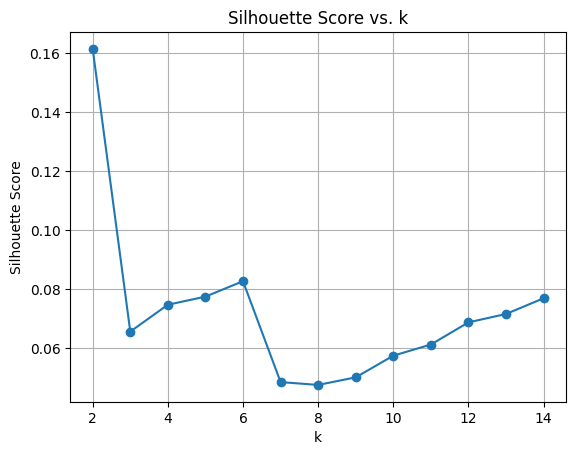

In [7]:

scores = []
k_values = range(2, 15)
for k in k_values:
    km = KMeans(n_clusters=k, random_state=42)
    preds = km.fit_predict(tfidf_reduced)
    score = silhouette_score(tfidf_reduced, preds)
    scores.append(score)

plt.plot(k_values, scores, marker='o')
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs. k")
plt.grid(True)
plt.show()


## Final KMeans Clustering

In [8]:

best_k = 10  # You can change based on the silhouette plot
kmeans = KMeans(n_clusters=best_k, random_state=42)
df['Cluster'] = kmeans.fit_predict(tfidf_reduced)


## Visualize Clusters with t-SNE

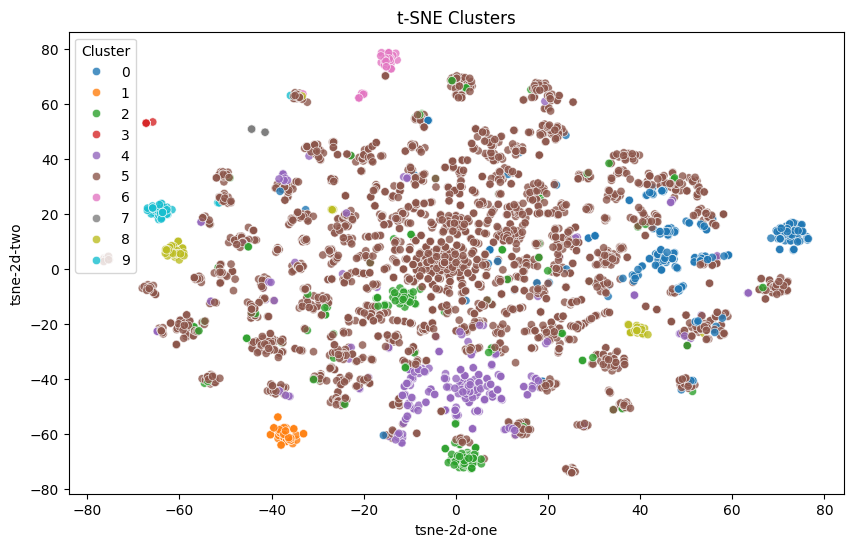

In [9]:

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(tfidf_reduced)
df['tsne-2d-one'] = tsne_result[:,0]
df['tsne-2d-two'] = tsne_result[:,1]

plt.figure(figsize=(10,6))
sns.scatterplot(
    x='tsne-2d-one', y='tsne-2d-two',
    hue='Cluster',
    palette=sns.color_palette('tab10', n_colors=best_k),
    data=df,
    legend='full',
    alpha=0.8
)
plt.title("t-SNE Clusters")
plt.show()


## Top Terms Per Cluster

In [10]:

def get_top_terms_per_cluster(tfidf_matrix, labels, vectorizer, n_terms=10):
    terms = vectorizer.get_feature_names_out()
    df_terms = pd.DataFrame(tfidf_matrix.todense()).groupby(labels).mean()
    for i, row in df_terms.iterrows():
        print(f"\nCluster {i}:")
        print(", ".join([terms[t] for t in row.argsort()[::-1][:n_terms]]))

get_top_terms_per_cluster(tfidf_matrix, df['Cluster'], vectorizer)



Cluster 0.0:
glass, christmas, holder, light holder, light, red, rose, bracelet, retrospot, scissor

Cluster 1.0:
charlie lola, charlie, lola, hot water, water bottle, water, hot, colours, cushions, bottle

Cluster 2.0:
heart, set, red, vintage, white, decoration, black, blue, bunting, metal sign

Cluster 3.0:
light, light candles, bird light, candles, bird, bowl, french enamel, green, water, french

Cluster 4.0:
metal, blue, set, sign, metal sign, party, boxes, small, tea, christmas

Cluster 5.0:
set, pink, box, red, design, blue, heart, retrospot, bag, vintage

Cluster 6.0:
red, wicker, doormat union, tin, heart small, tier cake, cake tin, wicker heart, cake, tier

Cluster 7.0:
microwave, ping, ping microwave, apron, feeder, feathers curtain, feathers, feather tree, feather pen, feather christmas

Cluster 8.0:
blue, white, peace, crossbones, caravan, light holder, woven, doorstop, set 12, white lace

Cluster 9.0:
heart, wall art, art, wall, heart decoration, heart card, cat bird, de

## Evaluation - Silhouette Score

In [11]:

score = silhouette_score(tfidf_reduced, df['Cluster'])
print(f"Silhouette Score: {score:.4f}")


Silhouette Score: 0.0573


In [14]:
from sklearn.metrics.pairwise import cosine_similarity

product_idx = 5
cos_sim = cosine_similarity(tfidf_matrix[product_idx], tfidf_matrix).flatten()
top_indices = cos_sim.argsort()[::-1][1:6]

print("Selected Product:\n", df.iloc[product_idx]['Description'])
print("\nTop 5 Similar Products:\n")
for i in top_indices:
    print(f"- {df.iloc[i]['Description']} (Similarity: {cos_sim[i]:.2f})")


Selected Product:
 set 7 babushka nesting boxes

Top 5 Similar Products:

- stripey chocolate nesting boxes (Similarity: 0.54)
- pink spots chocolate nesting boxes  (Similarity: 0.50)
- set of 3 babushka stacking tins (Similarity: 0.42)
- set of 3 coney island oval boxes (Similarity: 0.24)
- set 4 nursery des round boxes (Similarity: 0.21)


In [16]:
import joblib

# Save the models
joblib.dump(vectorizer, 'model/tfidf_vectorizer.pkl')
joblib.dump(svd, 'model/svd_transformer.pkl')
joblib.dump(kmeans, 'model/kmeans_model.pkl')

# Save the original DataFrame (with clusters and text)
df.to_pickle('model/product_data.pkl')
